# Script to get data from the Rigol 1054Z scope and plot it
This  script was written to get a voltage trace from a scope which measures a bicycle dynamo with different loads attached. 
16.3.20,pet

In [42]:
#scope
from ds1054z import DS1054Z
#plot
import matplotlib.pyplot as plt
import numpy as np
#filter
from scipy.signal import butter,filtfilt# Filter requirements.
from scipy.signal import blackmanharris, correlate
from numpy.fft import rfft
from numpy import argmax, mean, diff, log, nonzero
from numpy import polyfit, arange


# Scope 

In [185]:
scope = DS1054Z('192.168.0.98')
print("Connected to: ", scope.idn)

print("Currently displayed channels: ", str(scope.displayed_channels))

Connected to:  RIGOL TECHNOLOGIES,DS1104Z,DS1ZA192812789,00.04.04.SP3
Currently displayed channels:  ['CHAN1']


In [134]:
#Get datapoints from the scope
wave_volt = np.array(scope.get_waveform_samples("CHAN1"))#,"MAX")
wave_time = np.array(scope.waveform_time_values)
print("got datapoints: "+str(len(wave_volt)))

got datapoints: 1200


# Filter & Calc

In [222]:
#The filter and calculate cell
T = wave_time[len(wave_time)-1] - wave_time[0]         # Sample Period
fs = 1/(wave_time[1]-wave_time[0])       # sample rate, Hz
cutoff = 1000      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hznyq = 0.5 * fs  # Nyquist Frequencyorder = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples
order = 2       # sin wave can be approx represented as quadratic
nyq = 0.5 * fs  # Nyquist Frequencyorder = 2       # sin wave can be approx represented as quadratic


# Filter the data
wave_volt_filtered = butter_lowpass_filter(wave_volt, cutoff, fs, order)

#calculate speed
wave_frequency = freq_from_fft(wave_volt, fs)
dynamo_revs = wave_frequency/4 #the dynamo makes 4 peaks per revolution
wheel_speed = 2*3.1415*0.03*dynamo_revs # speed is calculated over the circumference of the dynamo (30mm)
wheel_speed_kmh = wheel_speed*3.6# in km/h
print("Wheel speed: "+str(round(wheel_speed_kmh,3))+' km/h')

#calculate average power over the load resistor
resistance = 12.19 #measured resistance of power resistor
powerAVG = get_powerAVG_over_res(wave_volt, fs, T, resistance)
print("Average power over resistor: "+str(powerAVG)+"W")

Wheel speed: 30.563 km/h
Average power over resistor: 6.14W


In [171]:
#source: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [18]:
#source: https://gist.github.com/PedroLopes/52a6cdd473bcae43c258
def freq_from_fft(sig, fs):
    """
    Estimate frequency from peak of FFT
    """
    # Compute Fourier transform of windowed signal
    windowed = sig * blackmanharris(len(sig))
    f = rfft(windowed)

    # Find the peak and interpolate to get a more accurate peak
    i = argmax(abs(f))  # Just use this for less-accurate, naive version
    true_i = parabolic(log(abs(f)), i)[0]

    # Convert to equivalent frequency
    return fs * true_i / len(windowed)

In [19]:
def parabolic(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.

    f is a vector and x is an index for that vector.

    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.

    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.

    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]

    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)

    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)



In [91]:
def get_powerAVG_over_res(wave, fs, T, resistance):
    #takes the voltage waveform, the load resistance and makes an averaged power
    i=0
    power=0
    while i < len(wave):
        power=power+(wave[i]*wave[i]/resistance)*(1/fs)#E= P*t = U^2/R *t
        i=i+1
    return round(power/T,2)


# Plot

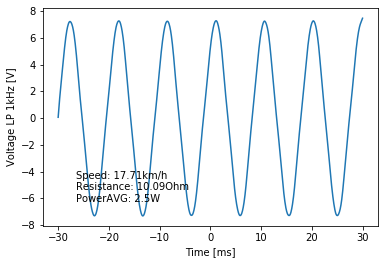

In [136]:
#Plots the data and saves it both as a PNG and as a CSV to edit later on
name="Measurements/Dynamo_"+str(round(wheel_speed_kmh,0))+"kmh_"+str(round(resistance,0))+"Ohm"

plt.plot(wave_time*1000, wave_volt_filtered)#, linewidth = 0.1)
#plt.plot(wave_time*1000, wave_volt*1.05)#, linewidth = 0.1)
plt.xlabel('Time [ms]')
plt.ylabel('Voltage LP 1kHz [V]')
textthing = "Speed: "+str(round(wheel_speed_kmh,2))+"km/h"+\
            "\n"+\
            "Resistance: "+str(resistance)+"Ohm"\
            "\n"+\
            "PowerAVG: "+str(powerAVG)+"W"
plt.annotate(textthing, xy=(1, 1),  xycoords='data',
            xytext=(0.1, 0.1), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            )
plt.savefig(name+'.png', dpi = 600)

data_stacked = np.column_stack([wave_time,wave_volt,wave_volt_filtered])
np.savetxt( name+'.csv', data_stacked, delimiter=',', newline='\n', header='[TIME],[VOLT],[VOLT filtered 1kHz] \n') 


# Plot all powers vs speeds in one plot

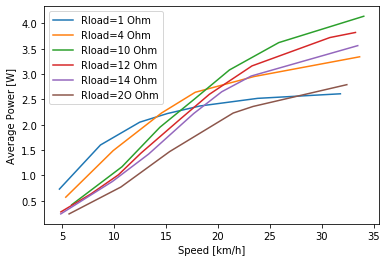

In [214]:
import csv
import numpy
name_1= "Measurements/powerVSspeed_1Ohm.csv"
name_4= "Measurements/powerVSspeed_4Ohm.csv"
name_10= "Measurements/powerVSspeed_10Ohm.csv"
name_12= "Measurements/powerVSspeed_12Ohm.csv"
name_14= "Measurements/powerVSspeed_14Ohm.csv"
name_20= "Measurements/powerVSspeed_20Ohm.csv"

csv_data_1 = numpy.loadtxt(open(name_1, "rb"), delimiter=",", skiprows=1)
csv_data_4 = numpy.loadtxt(open(name_4, "rb"), delimiter=",", skiprows=1)
csv_data_10 = numpy.loadtxt(open(name_10, "rb"), delimiter=",", skiprows=1)
csv_data_12 = numpy.loadtxt(open(name_12, "rb"), delimiter=",", skiprows=1)
csv_data_14 = numpy.loadtxt(open(name_14, "rb"), delimiter=",", skiprows=1)
csv_data_20 = numpy.loadtxt(open(name_20, "rb"), delimiter=",", skiprows=1)

speed_1 = csv_data_1[:][:,0]
powerAVG_1 = csv_data_1[:][:,1]
speed_4 = csv_data_4[:][:,0]
powerAVG_4 = csv_data_4[:][:,1]
speed_10 = csv_data_10[:][:,0]
powerAVG_10 = csv_data_10[:][:,1]
speed_12 = csv_data_12[:][:,0]
powerAVG_12 = csv_data_12[:][:,1]
speed_14 = csv_data_14[:][:,0]
powerAVG_14 = csv_data_14[:][:,1]
speed_20 = csv_data_20[:][:,0]
powerAVG_20 = csv_data_20[:][:,1]

plt.plot(speed_1, powerAVG_1, label='Rload=1 Ohm')
plt.plot(speed_4, powerAVG_4, label='Rload=4 Ohm')
plt.plot(speed_10, powerAVG_10, label='Rload=10 Ohm')
plt.plot(speed_12, powerAVG_12, label='Rload=12 Ohm')
plt.plot(speed_14, powerAVG_14, label='Rload=14 Ohm')
plt.plot(speed_20, powerAVG_20, label='Rload=2O Ohm')


plt.legend()
#plt.plot(wave_time*1000, wave_volt*1.05)#, linewidth = 0.1)
plt.xlabel('Speed [km/h]')
plt.ylabel('Average Power [W]')
plt.savefig("powerVSspeed_all_res"+'.png', dpi = 600)